<a href="https://colab.research.google.com/github/pedroconcejero/deep_learning_CNN/blob/main/%5BPrivate%5D%5BU_tad%5D_Very_basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'private-u-tad-dogs-vs-cats-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F85781%2F9710566%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241007%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241007T161259Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91ca966aeaec216bcd0aa92b28e28d4307ce72d2f3738511a1b2955fc66ac40b58bd103c929dab55cf6622f4807eb108ba1c1ab0fe86918c3df7014986da9d051acfd834af5e9c286bc520908a120124c7c53e67d0dd6aa5661afce735aac23b5e09397aacf4c3c8a0c7ae8d8ec3e532aa78d1937a834a2fb357ab5ad2d00d21487e17d629ca485a9b0b2650f016d3209dd353c21719f10aa5c10c8e4badee53cc261feb309c06680aef8a0d13fdfe921deddd40e40f630459baedc855e7b7066d6220aa99ce3d76ab788433772cfa51729e609168a68f3076328c2f2d896a3e294606b6876d37d669d10f3333a56bd237704be80761d348e96fd2caa2a92c08'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1821840102 bytes downloaded
Downloaded and uncompressed: private-u-tad-dogs-vs-cats-2024
Data source import complete.


In [10]:
# Lista los archivos y carpetas en el directorio especificado
ruta_directorio = "/kaggle/input/private-u-tad-dogs-vs-cats-2024/train/train"
contenido = os.listdir(ruta_directorio)

# Imprime la lista de archivos y directorios
for item in contenido:
    print(item)


Dog
Cat


In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2
from random import shuffle

# Read in the training data

In [11]:
image_size = (256, 256)
batch_size = 128

# https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    #"/kaggle/input/private-u-tad-dogs-vs-cats-2024",
    "/kaggle/input/private-u-tad-dogs-vs-cats-2024/train/train",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred"
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


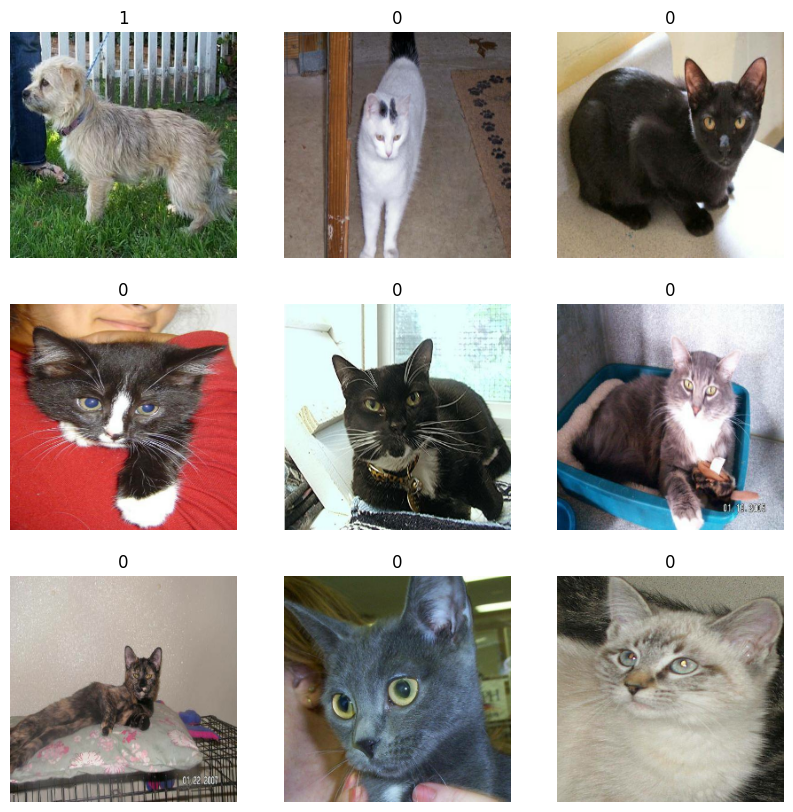

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# CNN básico

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
#me estoy basando en el libro de jordi torres, yo tengo la primera edicion, y he estado adaptando las cosas que ponian lo mejor que he podido
#con resultados medianamente decentes, no se si ha sido suerte, pero la acc ha subido de un 0.5 a un 0.598
modelDA = Sequential()
modelDA.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelDA.add(MaxPooling2D((2, 2)))
modelDA.add(Conv2D(64, (3, 3), activation='relu'))
modelDA.add(MaxPooling2D((2, 2)))
modelDA.add(Conv2D(128, (3, 3), activation='relu'))
modelDA.add(MaxPooling2D((2, 2)))
modelDA.add(Flatten())
modelDA.add(Dense(512, activation='relu'))
modelDA.add(Dense(1, activation='sigmoid'))

modelDA.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,076,673 (225.36 MB)

 Trainable params: 59,076,673 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and train

In [13]:
modelDA.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],)

epochs = 60

modelDA.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,)

Epoch 1/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 371ms/step - acc: 0.5877 - loss: 61.9763 - val_acc: 0.7376 - val_loss: 0.5350
Epoch 2/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 308ms/step - acc: 0.7729 - loss: 0.4754 - val_acc: 0.7656 - val_loss: 0.5090
Epoch 3/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - acc: 0.8429 - loss: 0.3562 - val_acc: 0.7546 - val_loss: 0.5507
Epoch 4/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - acc: 0.8841 - loss: 0.2724 - val_acc: 0.7730 - val_loss: 0.5657
Epoch 5/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 283ms/step - acc: 0.9252 - loss: 0.1904 - val_acc: 0.7488 - val_loss: 0.6863
Epoch 6/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 288ms/step - acc: 0.9442 - loss: 0.1519 - val_acc: 0.7672 - val_loss: 0.6743
Epoch 7/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 308ms/step - acc: 0.9564 - loss: 0.1204 - val_acc: 0.7576 - val_loss: 0.7799
Epoch 8/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 282ms/step - acc: 0.9669 - loss: 0.0967 - val_acc: 0.7628 - val_loss: 0.8396
Epoch 9/60
157/157 ━━━━━━━━━━━━

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Lista los archivos y carpetas en el directorio especificado
ruta_directorio = "/kaggle/input/private-u-tad-dogs-vs-cats-2024/test/test/"
contenido = os.listdir(ruta_directorio)

# Imprime la lista de archivos y directorios
for item in contenido:
    print(item)


985.jpg
384.jpg
457.jpg
57.jpg
15.jpg
281.jpg
23.jpg
924.jpg
272.jpg
1053.jpg
144.jpg
775.jpg
62.jpg
569.jpg
198.jpg
977.jpg
119.jpg
530.jpg
51.jpg
976.jpg
45.jpg
889.jpg
894.jpg
950.jpg
467.jpg
1.jpg
283.jpg
879.jpg
836.jpg
740.jpg
741.jpg
362.jpg
661.jpg
11.jpg
999.jpg
1008.jpg
236.jpg
365.jpg
227.jpg
673.jpg
752.jpg
503.jpg
463.jpg
755.jpg
770.jpg
285.jpg
214.jpg
750.jpg
20.jpg
713.jpg
989.jpg
205.jpg
1027.jpg
19.jpg
392.jpg
72.jpg
78.jpg
242.jpg
43.jpg
231.jpg
2.jpg
805.jpg
671.jpg
868.jpg
908.jpg
1028.jpg
303.jpg
230.jpg
858.jpg
680.jpg
831.jpg
638.jpg
791.jpg
803.jpg
887.jpg
428.jpg
180.jpg
102.jpg
596.jpg
900.jpg
5.jpg
505.jpg
228.jpg
468.jpg
426.jpg
507.jpg
335.jpg
636.jpg
94.jpg
469.jpg
838.jpg
12.jpg
783.jpg
168.jpg
171.jpg
136.jpg
970.jpg
839.jpg
521.jpg
402.jpg
882.jpg
745.jpg
97.jpg
167.jpg
857.jpg
637.jpg
933.jpg
188.jpg
724.jpg
418.jpg
190.jpg
161.jpg
593.jpg
779.jpg
1065.jpg
809.jpg
804.jpg
737.jpg
433.jpg
574.jpg
292.jpg
446.jpg
965.jpg
260.jpg
212.jpg
725.jpg
58.jpg
8

# Create predictions for all test images

In [19]:
folder_path = "/kaggle/input/private-u-tad-dogs-vs-cats-2024/test/test/"

# below 0.5 is a cat, above 0.5 is a dog
discrimination_threshold = 0.5
predictions_dict = {}

for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)

    # save the image name
    file_name = img.split('/')[-1]
    file_no_extension = file_name.split('.')[0]

    img = keras.utils.load_img(img, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)
    predictions = modelDA.predict(img_array, verbose=None)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    label = (score > discrimination_threshold )*1

    # save the predictions to a dictionary
    predictions_dict[int(file_no_extension)] = label

# Save predictions to a competition submission file

In [20]:
submission = pd.DataFrame(predictions_dict.items(), columns=["id", "label"]).sort_values(by='id', ascending=True)
submission.to_csv('submission.csv',index=False)

# print numbers of each class label
submission["label"].value_counts()

,count
label,
1,825
0,242


In [35]:
test_ds = keras.utils.image_dataset_from_directory(
    #"/kaggle/input/private-u-tad-dogs-vs-cats-2024",
    "/kaggle/input/private-u-tad-dogs-vs-cats-2024/test",
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred"
)

Found 1067 files belonging to 1 classes.


In [36]:
# Pruebo el modelo


test_loss_tl, test_accuracy_tl = modelDA.evaluate(test_ds)

print('Test loss:', f"{test_loss_tl:.4f}")
print("Test accuracy: ", f"{test_accuracy_tl:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - acc: 0.5128 - loss: 7.5857
Test loss: 7.5000
Test accuracy:  0.5061
